# Introduction

**This notebook contains the exploratory data analysis and some data preparation performed on the Flickr8k dataset. The dataset contains 8092 unique images with 5 captions associated with every image which describes the salient features of the images. For ex.** 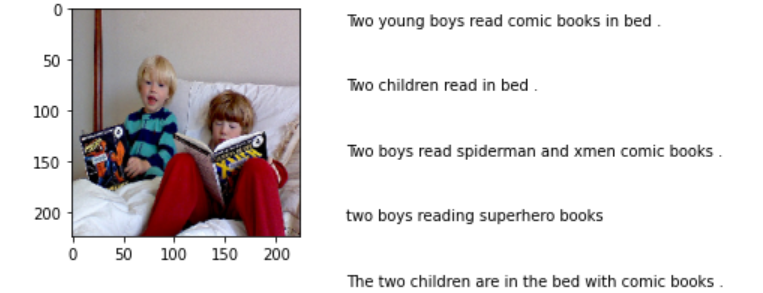

The decision to use Flickr8k instead of Flickr30k or MS-COCO was driven by the limited computational power available to us.

In [1]:
# Mounting the google drive containing the dataset
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive




**Importing relevant libraries**


In [2]:
import os
import time
import pickle
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
import heapq
import warnings
warnings.filterwarnings('ignore')
import random
from collections import Counter


# Loading data and removing inconsistencies

**Reading the captions. As per description there are 5 captions associated with each picture.**




In [3]:
base_path = '/content/gdrive/My Drive/Image-Captioning/'
path_captions = base_path + 'Data/'
df_captions = pd.read_csv(path_captions + 'captions.txt', sep = ',')
# Getting a list of all unique image names for which a caption entry is present.
list_images_in_captions = list(df_captions['image'].unique())
print('There are ', len(df_captions), ' captions associated with ', len(list_images_in_captions), ' images.')
display(df_captions.head())

There are  40455  captions associated with  8091  images.


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


**Reading the images.**

In [4]:
path_images = base_path + 'Data/Images/'
list_all_images = os.listdir(path_images)
print('Number of images in the dataset : ', len(list_all_images))

Number of images in the dataset :  8109


**The mismatch in the numbers suggest that no captions are associated with a few images. We'll getting rid of such images for training.**



In [5]:
# Putting the images in a dictionary to enable O(N) search
dict_all_images_in_captions = {image_name : True for image_name in list_images_in_captions}
list_images_without_captions = []

for image_name in list_all_images:
  try:
    dict_all_images_in_captions[image_name]
  except:
    list_images_without_captions.append(image_name)

# Removing the images without captions
list_all_images = list(set(list_all_images) - set(list_images_without_captions))
print(len(list_images_without_captions) , ' images were found without any captions.')

# Removing the captions for which an image is not present
df_captions = df_captions.loc[df_captions['image'].isin(list_all_images)]
df_captions.set_index('image').loc[list_all_images, :]  # Ordering the dataframe in order of list_all_images
#df_captions['image'] = list(df_captions.index)#
df_captions.reset_index(drop = True, inplace = True)

18  images were found without any captions.


# EDA

**Visualizing a few examples.**

In [6]:
def display_image_with_captions(image_file_name):
  '''
  Picks the corresponding image from the directory and shows the captions associated with it.
  '''

  image = load_img(path_images + image_file_name, target_size = (224, 224, 3))
  relevant_captions = list(df_captions.loc[df_captions['image'] == image_file_name, 'caption'])

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(image)
  ax = fig.add_subplot(1, 2, 2)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0, 1)
  ax.set_ylim(0, len(relevant_captions))
  for idx, caption in enumerate(relevant_captions):
    ax.text(0, idx, caption, fontsize=10)
  
  plt.axhline(y=len(relevant_captions), color='k', linestyle='-')
  plt.show()


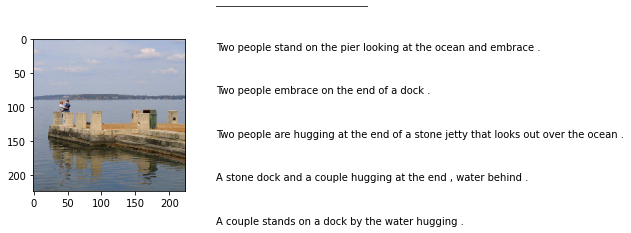

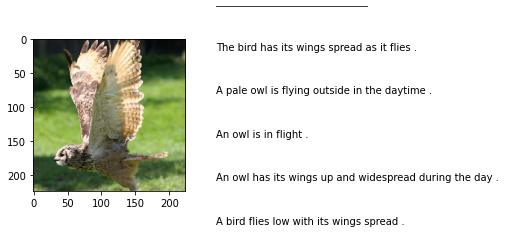

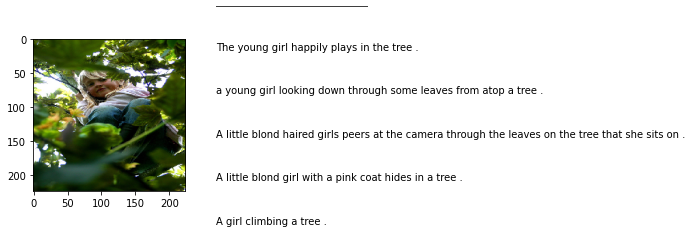

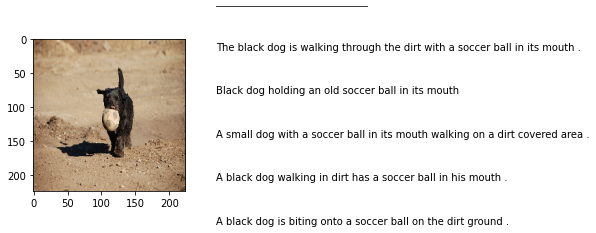

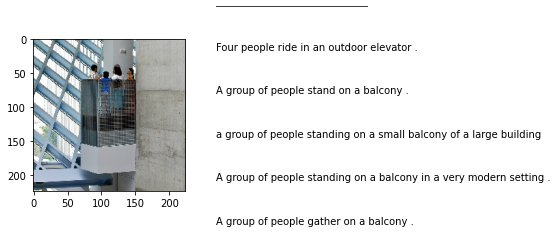

In [7]:
# Printing 5 random images and their captions
for i in range(5):
  random_image_file = random.sample(list_all_images, k = 1)[0]  # Picking a random image
  display_image_with_captions(random_image_file)

**Observations:**

**1. Most of the captions appear to contain a space before '.'. If that holds for most of the dataset, count of spaces in a caption can be used to get the number of words in that caption.**

**2. A few captions don't have '.'**



In [8]:
# As described above, checking how many captions have a ' .' at the end.
count = 0
for caption in list(df_captions['caption']):
  if caption.endswith(' .'):
    count += 1
print(count, " captions out of total ", len(df_captions), " captions have ' .' at the end")


36557  captions out of total  40455  captions have ' .' at the end


In [9]:
# Since most of the captions contain ' .' at the end, using the number of spaces as a proxy for number of words in a caption.
# Defining a column 'caption_length' which represents the same
df_captions['caption_length'] = df_captions['caption'].str.count(' ')
display(df_captions.head())

,image,caption,caption_length
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,17
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,7
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,8
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,9
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,12


Text(0.5, 1.0, 'Probability histogram plot of number of words in each caption.')

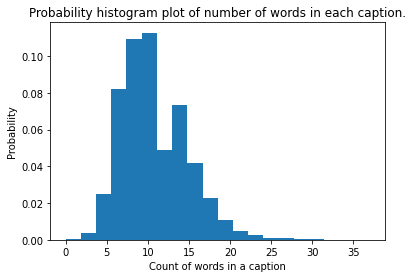

In [10]:
# Plotting a probability histogram of the number of words in a caption
len_captions = list(df_captions['caption_length'])
_ = plt.hist(x = len_captions, density = True, bins = 20)
plt.xlabel('Count of words in a caption')
plt.ylabel('Probability')
plt.title('Probability histogram plot of number of words in each caption.')

**The plot tells us that most of the captions are of lengths between 6 and 11 with very few ones with length > 25 and < 5.**

In [11]:
# Defining standard deviation in the caption lengths for the same image. It can  indicate the degree of difference
# in labelling the same image from two different labellers.
std_caption_length = df_captions.groupby('image')['caption_length'].std()
std_caption_length = pd.DataFrame(std_caption_length)
std_caption_length.columns = ['std_caption_length']
std_caption_length['image'] = list(std_caption_length.index)
std_caption_length.reset_index(drop = True, inplace = True)


Text(0.5, 1.0, 'Probability histogram of standard deviation of caption lengths')

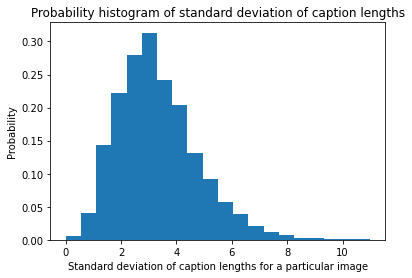

In [12]:
# Plotting the probability histogram of the standard deviation of the number of words in a caption. 
df_captions = pd.merge(df_captions, std_caption_length, on = 'image')

_ = plt.hist(x = list(df_captions['std_caption_length']), density = True, bins = 20)
plt.xlabel('Standard deviation of caption lengths for a particular image')
plt.ylabel('Probability')
plt.title('Probability histogram of standard deviation of caption lengths')


**For most of the captions, the standard deviation of word count is fairly low. However, for a few is extemely high. Examining top 5 of such images.**

[10.99090533122727, 10.876580344942981, 10.802777420645118, 10.606601717798213, 10.4546640309481]


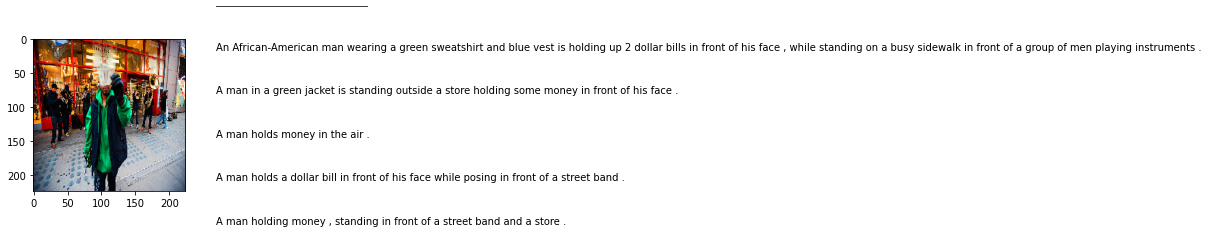

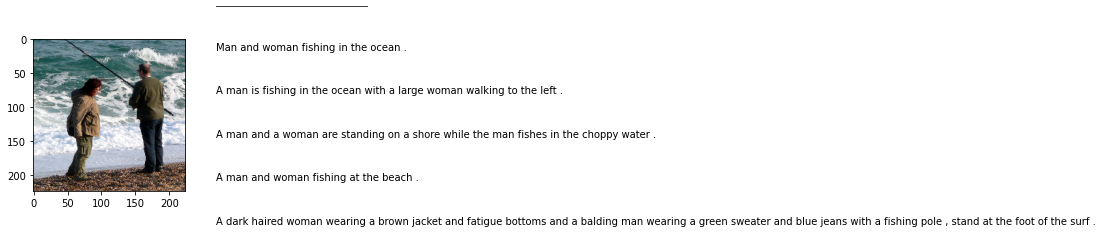

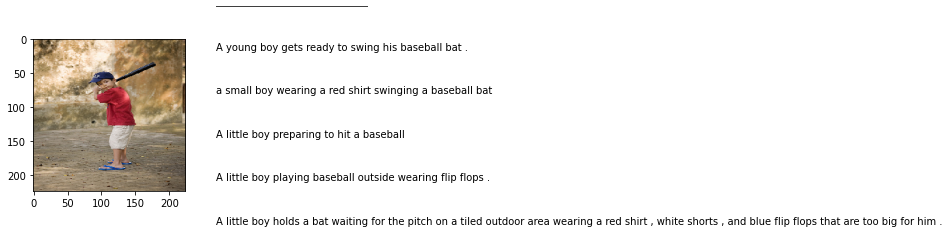

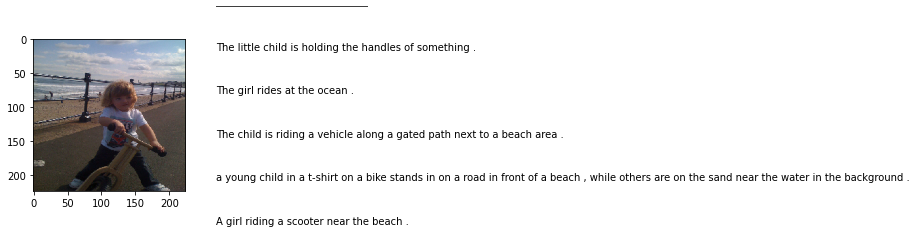

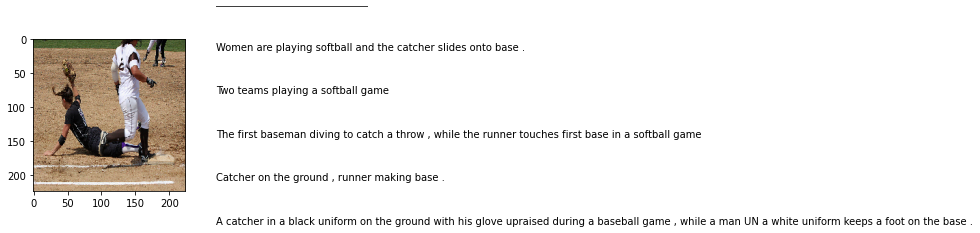

In [13]:
top_5_std = heapq.nlargest(5, list(df_captions['std_caption_length'].unique()))
print(top_5_std)
for std in top_5_std:
  image_file = df_captions.loc[df_captions['std_caption_length'] == std, 'image'].iloc[0]
  display_image_with_captions(image_file)

**The images with high standard deviation in their caption lengths appear to have a few over-detailed captions. Whereas the captions of lesser length of the same image are concise. Given that we've a relatively smaller training dataset, captions containing over-detailed information might lead to overfitting. Hence, for each image, we'll be keeping only the caption of the least length. As a future exercise, when we use MS-COCO for training purposes, we'll be keeping all the 5 captions.**

In [14]:
# Calculating the min caption length for each image
captions_min_length = df_captions.groupby('image')['caption_length'].min()
captions_min_length = pd.DataFrame(captions_min_length)
captions_min_length.columns = ['min_caption_length']
captions_min_length['image'] = list(captions_min_length.index)
captions_min_length.reset_index(drop = True, inplace = True)

# Keeping only the caption with the min length. In case of multiple such captions, keep the first one.
df_captions = pd.merge(df_captions[['image', 'caption', 'caption_length']],
                         captions_min_length, left_on = ['image', 'caption_length'], right_on = ['image', 'min_caption_length'])
df_captions = df_captions.drop_duplicates(subset = ['image'], keep = 'first')
del(df_captions['caption_length'])
del(df_captions['min_caption_length'])
display(df_captions.head())

,image,caption
0,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
3,1002674143_1b742ab4b8.jpg,Young girl with pigtails painting outside in t...
4,1003163366_44323f5815.jpg,man laying on bench holding leash of dog sitti...
5,1007129816_e794419615.jpg,A man wears an orange hat and glasses .


**Examining what words occur most frequently and least frequently in the captions**

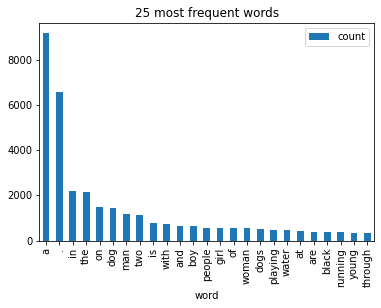

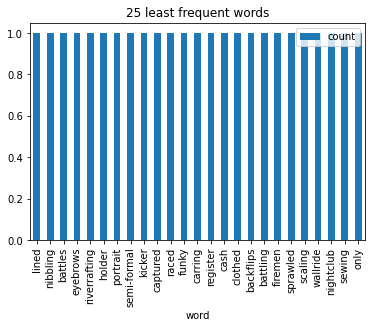

In [15]:
# Checking the most and least frequent words
list_all_words = []
for caption in list(df_captions['caption']):
  list_all_words += caption.lower().split()

word_counts = Counter(list_all_words)
df_word_counts = pd.DataFrame.from_dict(word_counts, orient='index')
df_word_counts['word'] = list(df_word_counts.index)
df_word_counts.columns = ['count', 'word']
df_word_counts = df_word_counts.sort_values(by = 'count', ascending = False)
df_word_counts.reset_index(drop = True, inplace = True)
df_word_counts_top_25 = df_word_counts.iloc[:25]
df_word_counts_bottom_25 = df_word_counts.iloc[-25:]
df_word_counts_top_25.plot(x = 'word',kind='bar', title = '25 most frequent words')
df_word_counts_bottom_25.plot(x = 'word',kind='bar', title = '25 least frequent words')

**Observations:**

**1. 'a' occurs in almost every caption, with multiple occurences in few captions.**

**2. A significant numbers of images have dogs and/or man present. In the final predictions on the test data, we might see the model to be positively biased towards identifying men/boys compared to women/girls.**

**3. Most of the least frequent words are specialized ones like 'nibbling', 'battling', 'sprawled' etc.**


**Splitting the dataset into train/ val/ test. Given the small dataset, we'll divide the it into percentages of 75/ 12.5/ 12.5**

In [16]:
df_captions_train = df_captions.sample(frac = 0.75, random_state = 1087)
df_captions_test_val = df_captions.drop(df_captions_train.index)
df_captions_val = df_captions_test_val.sample(frac = 0.5, random_state = 1087)
df_captions_test = df_captions_test_val.drop(df_captions_val.index)
df_captions_train.reset_index(drop = True, inplace = True)
df_captions_val.reset_index(drop = True, inplace = True)
df_captions_test.reset_index(drop = True, inplace = True)

print('Number of images in train set: ', len(df_captions_train))
print('Number of images in validation set: ', len(df_captions_val))
print('Number of images in test set: ', len(df_captions_test))

Number of images in train set:  6068
Number of images in validation set:  1012
Number of images in test set:  1011


# Data cleaning

**Cleaning the caption data**

**1. Remove punctuations and special characters eg. '.', '$'**

**2. Remove words with numbers in them eg. 's7'**

**3. Lower case all words eg. 'Dog' becomes 'dog'**

**4. Add 'sos' (start of sentence) at the beginning of a caption and 'eos' (end of sentence) at the end of it**

**5. Only use the words whose unique count crosses a certain threshold in the training set. Replace all other words with 'unk' (unknown). Note that all gibberish words would become 'unk'**

**Note that we don't want to perform stemming/lemmatization here i.e.  words like 'playing' will not be converted to 'play'**

In [17]:
# Obtaining word counts in the training set
list_all_words_train = []
for caption in list(df_captions_train['caption']):
  list_all_words_train += caption.lower().split()

dict_word_counts_train = Counter(list_all_words_train)

In [18]:
def caption_data_cleaning(caption, threshold):
  '''
  Apply the above written data cleaning steps to a single caption.
  threshold is the minimum frequency of any word required to keep it.
  Returns a 'clean' string
  '''
  caption = caption.split()
  caption_cleaned = ['sos ']

  for word in caption:
    if word.isalpha() is True:
      if dict_word_counts_train[word.lower()] >= threshold:
        caption_cleaned.append(word.lower() + ' ')
      else:
        caption_cleaned.append('unk ')
  
  caption_cleaned.append('eos')
  caption_cleaned = ''.join(caption_cleaned)

  return caption_cleaned


In [19]:
# Checking if the function is working as expected
caption = 'Amar Srivastava Is running on a 1km field volunsjfsd .'
print(caption_data_cleaning(caption, threshold = 1))

sos unk unk is running on a field unk eos


In [20]:
# Cleaning all the captions (train + test + val)
# We keep the frequency threshold at 5
df_captions_train['caption_cleaned'] = df_captions_train['caption'].apply(caption_data_cleaning, args = [5])
df_captions_test['caption_cleaned'] = df_captions_test['caption'].apply(caption_data_cleaning, args = [5])
df_captions_val['caption_cleaned'] = df_captions_val['caption'].apply(caption_data_cleaning, args = [5])

display(df_captions.head())

,image,caption
0,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
3,1002674143_1b742ab4b8.jpg,Young girl with pigtails painting outside in t...
4,1003163366_44323f5815.jpg,man laying on bench holding leash of dog sitti...
5,1007129816_e794419615.jpg,A man wears an orange hat and glasses .


# Data pre-processing

**Pre-processing of captions data:**

**1. Tokenization to convert words into integers. Obtain a mapping between the integers and corresponding words.**

**2. Convert sentences to words. Eg. 'a dog is playing' becomes ['a', 'dog', 'is', 'playing'] and then to their tokenized representations eg: [1, 8, 11, 21]**

**3. GloVe 50D word embeddings are obtained for the words present in out vocabulary for a dense representation of the captions.**

**4. Padding is done to make all the captions of the same length. This step will be performed in the Modelling & Evaluation notebook using Keras's pad_sequences function.**


In [21]:
# Tokenizing the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(df_captions_train['caption_cleaned']))

In [23]:
# Checking the output of the Tokenizer module
print(tokenizer.document_count, ' captions found in the training set.\n')
# tokenizer.word_counts  # Gives the number of occurrence of each word
print('Top 10 frequent words: \n', sorted(tokenizer.word_counts.items(), key = lambda kv: kv[1], reverse = True)[:10], '\n')
# tokenizer.word_docs  # Tells us what word occurs in how many captions
print('Top 10 word_docs\n', sorted(tokenizer.word_docs.items(), key = lambda kv: kv[1], reverse = True)[:10], '\n')
print('Example of dictionary of word indices: \n', {k: tokenizer.word_index[k] for k in list(tokenizer.word_index)[:10]}, '\n')  # Gives the dictionary mapping specific words to their indices


6068  captions found in the training set.

Top 10 frequent words: 
 [('a', 6889), ('sos', 6068), ('eos', 6068), ('unk', 3910), ('in', 1701), ('the', 1613), ('on', 1113), ('dog', 1067), ('man', 896), ('two', 845)] 

Top 10 word_docs
 [('sos', 6068), ('eos', 6068), ('a', 4480), ('unk', 2733), ('in', 1633), ('the', 1452), ('on', 1101), ('dog', 1031), ('man', 884), ('two', 842)] 

Example of dictionary of word indices: 
 {'a': 1, 'sos': 2, 'eos': 3, 'unk': 4, 'in': 5, 'the': 6, 'on': 7, 'dog': 8, 'man': 9, 'two': 10} 



**We observe that there are a very high number of unknown words in the dictionary, occuring in almost 50% of the captions**

In [24]:
vocab_size = len(tokenizer.word_index) + 1 # The number of words in the vocabulary
# Converting each of the captions in df_captions to tokens
encoded_captions_train = tokenizer.texts_to_sequences(list(df_captions_train['caption_cleaned']))
encoded_captions_test = tokenizer.texts_to_sequences(list(df_captions_test['caption_cleaned']))
encoded_captions_val = tokenizer.texts_to_sequences(list(df_captions_val['caption_cleaned']))
print('Size of the vocabulary is ', vocab_size)
print('Example of encoded captions: ', encoded_captions_train[:3])

Size of the vocabulary is  782
Example of encoded captions:  [[2, 8, 188, 36, 446, 14, 25, 446, 3], [2, 10, 18, 12, 1, 113, 3], [2, 72, 55, 1, 162, 3]]


In [25]:
# Checking the maximum length of the captions
df_captions_train['caption_cleaned_length'] = df_captions_train['caption_cleaned'].str.count(' ') + 1
display(df_captions_train.head())
max_length_caption = max(df_captions_train['caption_cleaned_length'])
print('\nThe maximum caption length in the training set is ', max_length_caption)

,image,caption,caption_cleaned,caption_cleaned_length
0,2500567791_101d5ddee3.jpg,Dog chasing brown cow and black cow,sos dog chasing brown cow and black cow eos,9
1,3143978284_ac086be9a3.jpg,Two woman with a baby,sos two woman with a baby eos,7
2,3426933951_2302a941d8.jpg,Boys outside a building .,sos boys outside a building eos,6
3,177302997_5b2d770a0a.jpg,A child on a fake horse ride .,sos a child on a unk horse ride eos,9
4,218342358_1755a9cce1.jpg,A cyclist wearing a red helmet is riding on th...,sos a cyclist wearing a red helmet is riding o...,13



The maximum caption length in the training set is  17


In [26]:
# Adding a column of encoded_caption to df_captions dataframes for train, test and val sets
encoded_captions_train_str = []
for encoded_caption in encoded_captions_train:
  encoded_captions_train_str.append(str(encoded_caption))
df_captions_train['encoded_caption'] = encoded_captions_train_str

encoded_captions_test_str = []
for encoded_captions in encoded_captions_test:
  encoded_captions_test_str.append(str(encoded_captions))
df_captions_test['encoded_caption'] = encoded_captions_test_str

encoded_captions_val_str = []
for encoded_captions in encoded_captions_val:
  encoded_captions_val_str.append(str(encoded_captions))
df_captions_val['encoded_caption'] = encoded_captions_val_str

display(df_captions_val.head())

,image,caption,caption_cleaned,encoded_caption
0,2086678529_b3301c2d71.jpg,A girl is in a dress .,sos a girl is in a dress eos,"[2, 1, 17, 11, 5, 1, 277, 3]"
1,2294688426_96c8614f1d.jpg,The man in the robe has gold on his beard .,sos the man in the unk has unk on his unk eos,"[2, 6, 9, 5, 6, 4, 200, 4, 7, 48, 4, 3]"
2,2384550175_e421d3a871.jpg,Children are playing on the swings at a park .,sos children are playing on the swings at a pa...,"[2, 32, 24, 21, 7, 6, 251, 22, 1, 115, 3]"
3,2657484970_610e18144f.jpg,People are boating near a mountain .,sos people are unk near a mountain eos,"[2, 15, 24, 4, 59, 1, 89, 3]"
4,3258397351_1a70f1993d.jpg,A child being interviewed by a man with a micr...,sos a child being unk by a man with a micropho...,"[2, 1, 30, 184, 4, 67, 1, 9, 12, 1, 727, 3]"


In [27]:
# Fetching GloVe 50D word embeddings for the words present in the training data
glove_vectors = open(base_path + 'glove.6B.50d.txt')
t0 = time.time()
embeddings_index = dict()

for line in glove_vectors:
  values = line.split()
  word = values[0]
  if word in tokenizer.word_index:
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  else:
    continue

glove_vectors.close()
print('Loaded %s word vectors.' % len(embeddings_index))
print('Time taken to get embeddings: ', time.time() - t0, ' sec')

Loaded 780 word vectors.
Time taken to get embeddings:  3.8922770023345947  sec


**We had 781 words in our vocabulary, however we only found the embedding vectors for 780. This implies that one word was not present in the GloVe representation. Checking which word it is.**

In [28]:
missing_word = list(set(tokenizer.word_index.keys()) - set(embeddings_index.keys()))
print('The missing word is ', missing_word[0])

The missing word is  rollerblader


In [29]:
# Creating a embeddings matrix for the words present in the training vocabulary. Each word would be represented by 50 numbers
embedding_matrix = np.zeros((max(tokenizer.word_index.values()) + 1,50))
for word, word_idx in tokenizer.word_index.items():
  try:
    embedding_vector = embeddings_index[word]
    embedding_matrix[word_idx] = embedding_vector
  except:
    print('Error in ', word)
    continue

print('Shape of the embedding_matrix is ', np.shape(embedding_matrix))

Error in  rollerblader
Shape of the embedding_matrix is  (782, 50)


In [30]:
print('Example of an embedding vector :\n', embedding_matrix[1])
# Note that the idx = 0 embedding vector is all zeroes since no word is indexed to 0

Example of an embedding vector :
 [ 0.21705     0.46515    -0.46757001  0.10082     1.01349998  0.74844998
 -0.53104001 -0.26256001  0.16812     0.13181999 -0.24909    -0.44185001
 -0.21739     0.51003999  0.13448    -0.43141001 -0.03123     0.20674001
 -0.78138    -0.20148    -0.097401    0.16088    -0.61835998 -0.18504
 -0.12461    -2.25259995 -0.22321001  0.5043      0.32257     0.15312999
  3.96359992 -0.71364999 -0.67012     0.28388     0.21738     0.14432999
  0.25926     0.23434     0.42739999 -0.44451001  0.13812999  0.36973
 -0.64288998  0.024142   -0.039315   -0.26036999  0.12017    -0.043782
  0.41012999  0.1796    ]


**Dumping the pickles required for Modeling & Evaluation**

In [ ]:
# Dumping pickles which are required for modelling and evaluation
if not os.path.exists(base_path + 'Pickles/'):
  os.makedirs(base_path + 'Pickles/')

with open(base_path + 'Pickles/' + 'embedding_matrix.p', 'wb') as output:
  pickle.dump(embedding_matrix, output)

with open(base_path + 'Pickles/' + 'word_index.p', 'wb') as output:
  pickle.dump(tokenizer.word_index, output)

with open(base_path + 'Pickles/' + 'df_captions_train.p', 'wb') as output:
  pickle.dump(df_captions_train, output)

with open(base_path + 'Pickles/' + 'df_captions_test.p', 'wb') as output:
  pickle.dump(df_captions_test, output)

with open(base_path + 'Pickles/' + 'df_captions_val.p', 'wb') as output:
  pickle.dump(df_captions_val, output)

with open(base_path + 'Pickles/' + 'max_length_caption.p', 'wb') as output:
  pickle.dump(max_length_caption, output)